## Is it a Dog or a Wolf?

In [1]:
#    This code is only here to check that your internet is enabled. It doesn't do anything else.
import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

In [2]:
# It's a good idea to ensure you're running the latest version of any libraries you need.
# `!pip install -Uqq <libraries>` upgrades to the latest version of <libraries>
# NB: You can safely ignore any warnings or errors pip spits out about running as root or incompatibilities
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai 'duckduckgo_search>=6.2'

In [3]:
!pip install -Uqq fastai 'duckduckgo_search>=6.2'

The basic steps we'll take are:

1. Use DuckDuckGo to search for images of "dog photos"
1. Use DuckDuckGo to search for images of "wolf photos"
1. Fine-tune a pretrained neural network to recognise these two groups
1. Try running this model on a picture of a wolf and see if it works.

## Step 1: Download images of dogs and non-dogs


In [5]:
from duckduckgo_search import DDGS #DuckDuckGo has changed the api so we need to update
from fastcore.all import *

def search_images(keywords, max_images=300): return L(DDGS().images(keywords, max_results=max_images)).itemgot('image')
import time, json

Let's start by searching for a dog photo and seeing what kind of result we get. We'll start by getting URLs from a search:

In [6]:
#NB: `search_images` depends on duckduckgo.com, which doesn't always return correct responses.
#    If you get a JSON error, just try running it again (it may take a couple of tries).
urls = search_images('dog photos', max_images=1)
urls[0]

'https://images.pexels.com/photos/257540/pexels-photo-257540.jpeg?cs=srgb&dl=pexels-pixabay-257540.jpg&fm=jpg'

...and then download a URL and take a look at it:

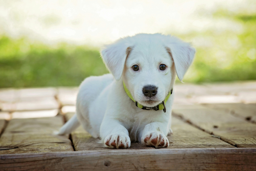

In [7]:
from fastdownload import download_url
dest = 'dog.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Now let's do the same with "wolf photos":

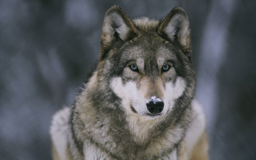

In [8]:
download_url(search_images('wolf photos', max_images=1)[0], 'wolf.jpg', show_progress=False)
Image.open('wolf.jpg').to_thumb(256,256)

Our searches seem to be giving reasonable results, so let's grab a few examples of each of "dog" and "wolf" photos, and save each group of photos to a different folder:

In [9]:
searches = 'dog','wolf'
path = Path('dog_or_not')

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    time.sleep(5)
    resize_images(path/o, max_size=400, dest=path/o)

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3570: UserWarning: image file could not be identified because AVIF support not installed
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3570: UserWarning: image file could not be identified because AVIF support not installed
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3570: UserWarning: image file could not be identified because AVIF support not installed
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3570: UserWarning: image file could not be identified because AVIF support not installed
  warnings.warn(message)


In [ ]:
# searches = 'dog','wolf'
# path = Path('dog_or_not')

# for o in searches:
#     dest = (path/o)
#     dest.mkdir(exist_ok=True, parents=True)

#     # Implement retry mechanism with exponential backoff
#     for i in range(5):  # Try up to 5 times
#         try:
#             download_images(dest, urls=search_images(f'{o} photo'))
#             break  # Exit the retry loop if successful
#         except RatelimitException as e:
#             print(f"Rate limit hit, retrying in {2**i} seconds...")
#             time.sleep(2**i)  # Wait for an increasing amount of time
#     else:
#         print(f"Failed to download images for {o} after multiple retries.")
#         continue  # Skip to the next search term

#     time.sleep(5)
#     resize_images(path/o, max_size=400, dest=path/o)

## Step 2: Train our model

Some photos might not download correctly which could cause our model training to fail, so we'll remove them:

In [10]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3570: UserWarning: image file could not be identified because AVIF support not installed
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3570: UserWarning: image file could not be identified because AVIF support not installed
  warnings.warn(message)


27

To train a model, we'll need `DataLoaders`, which is an object that contains a *training set* (the images used to create a model) and a *validation set* (the images used to check the accuracy of a model -- not used during training). In `fastai` we can create that easily using a `DataBlock`, and view sample images from it:

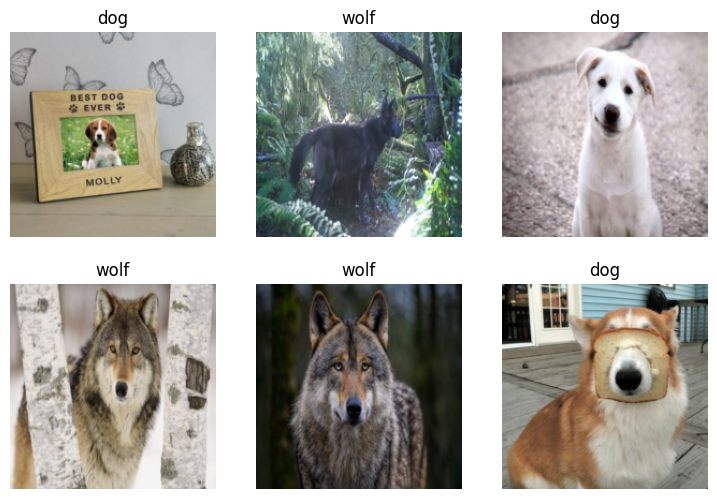

In [18]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=43),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

Here what each of the `DataBlock` parameters means:

    blocks=(ImageBlock, CategoryBlock),

The inputs to our model are images, and the outputs are categories (in this case, "bird" or "forest").

    get_items=get_image_files,

To find all the inputs to our model, run the `get_image_files` function (which returns a list of all image files in a path).

    splitter=RandomSplitter(valid_pct=0.2, seed=42),

Split the data into training and validation sets randomly, using 20% of the data for the validation set.

    get_y=parent_label,

The labels (`y` values) is the name of the `parent` of each file (i.e. the name of the folder they're in, which will be *bird* or *forest*).

    item_tfms=[Resize(192, method='squish')]

Before training, resize each image to 192x192 pixels by "squishing" it (as opposed to cropping it).

Now we're ready to train our model. The fastest widely used computer vision model is `resnet18`. You can train this in a few minutes, even on a CPU! (On a GPU, it generally takes under 10 seconds...)

`fastai` comes with a helpful `fine_tune()` method which automatically uses best practices for fine tuning a pre-trained model, so we'll use that.

In [12]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,0.444946,0.121887,0.036697,02:09


epoch,train_loss,valid_loss,error_rate,time
0,0.127484,0.147648,0.036697,03:06
1,0.089493,0.080146,0.013761,03:08
2,0.065053,0.082301,0.018349,03:08


| Epoch | Train Loss | Validation Loss | Error Rate | Time  | What It Means                                                     |
| ----- | ---------- | --------------- | ---------- | ----- | ----------------------------------------------------------------- |
| 0     | 0.127484   | 0.147648        | 3.7%       | 03:06 | Model might be adjusting — valid loss went up slightly.           |
| 1     | 0.089493   | 0.080146        | 1.4%       | 03:08 | Improvement — error rate dropped and model generalized better.    |
| 2     | 0.065053   | 0.082301        | 1.8%       | 03:08 | Still performing well, although slight fluctuation in validation. |


## Step 3: Use the model

Let's see what our model thinks about that wolf we downloaded at the start:

In [17]:
is_dog,_,probs = learn.predict(PILImage.create('dog.jpg'))
print(f"This is a: {is_dog}.")
print(f"Probability it's a dog: {probs[0]:.4f}")

This is a: dog.
Probability it's a dog: 1.0000


Good job, resnet18. :)

Now it's your turn. Click "Copy & Edit" and try creating your own image classifier using your own image searches!